<h1>Predict the Introverts from the Extroverts
<h2>Playground Series - Season 5, Episode 7

<h2><u>Summary : 

<h4>
<ol> 
<li> Import of librairies & data
<li> Data exploration
<li> Data cleaning & imputation
<li> Feature engineering

<h2>1. Import of librairies & data

In [66]:
import pandas as pd
import numpy as np
import sklearn
import pickle
import seaborn as sns
import missingno as mnso
import matplotlib.pyplot as plt
import xgboost

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute
from sklearn import tree

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer

print('Setup completed')

Setup completed


In [3]:
train = pd.read_csv('data/train.csv', index_col=['id'])
X_train = train.drop(columns=['Personality'],axis=1)
y_train = train.Personality
X_test = pd.read_csv('data/test.csv')
index = X_test.id

X_test = X_test.set_index('id')
X_data = pd.concat([X_train, X_test])
X_data.shape[0]==X_test.shape[0]+X_train.shape[0]

True

In [4]:
train.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           17334 non-null  float64
 1   Stage_fear                 16631 non-null  object 
 2   Social_event_attendance    17344 non-null  float64
 3   Going_outside              17058 non-null  float64
 4   Drained_after_socializing  17375 non-null  object 
 5   Friends_circle_size        17470 non-null  float64
 6   Post_frequency             17260 non-null  float64
 7   Personality                18524 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.3+ MB


In [6]:
train.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,3.137764,5.265106,4.044319,7.996737,4.982097
std,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [7]:
cat_f = ['Stage_fear', 'Drained_after_socializing']
num_f = ['Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size', 'Post_frequency' ]

In [10]:
print(train.isnull().sum()/train.shape[0]*100,X_test.isnull().sum()/X_test.shape[0]*100)

Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64 Time_spent_Alone             6.882591
Stage_fear                   9.684211
Social_event_attendance      6.429150
Going_outside                7.546559
Drained_after_socializing    6.995951
Friends_circle_size          5.668016
Post_frequency               6.607287
dtype: float64


We observe that there are a lot of missing values : between 5 to 10% according to the features. The imputation of these missing values will be one of the key work to prepare the values

In [11]:
train.isnull().sum(axis=1).value_counts()

0    10189
1     7516
2      779
3       38
4        2
Name: count, dtype: int64

The number of missing values could be an indicator ! Some people could feel akward answering some questions ! To be sure about that it could have been good to know how the data was collected. We are going to explore that with missingno.

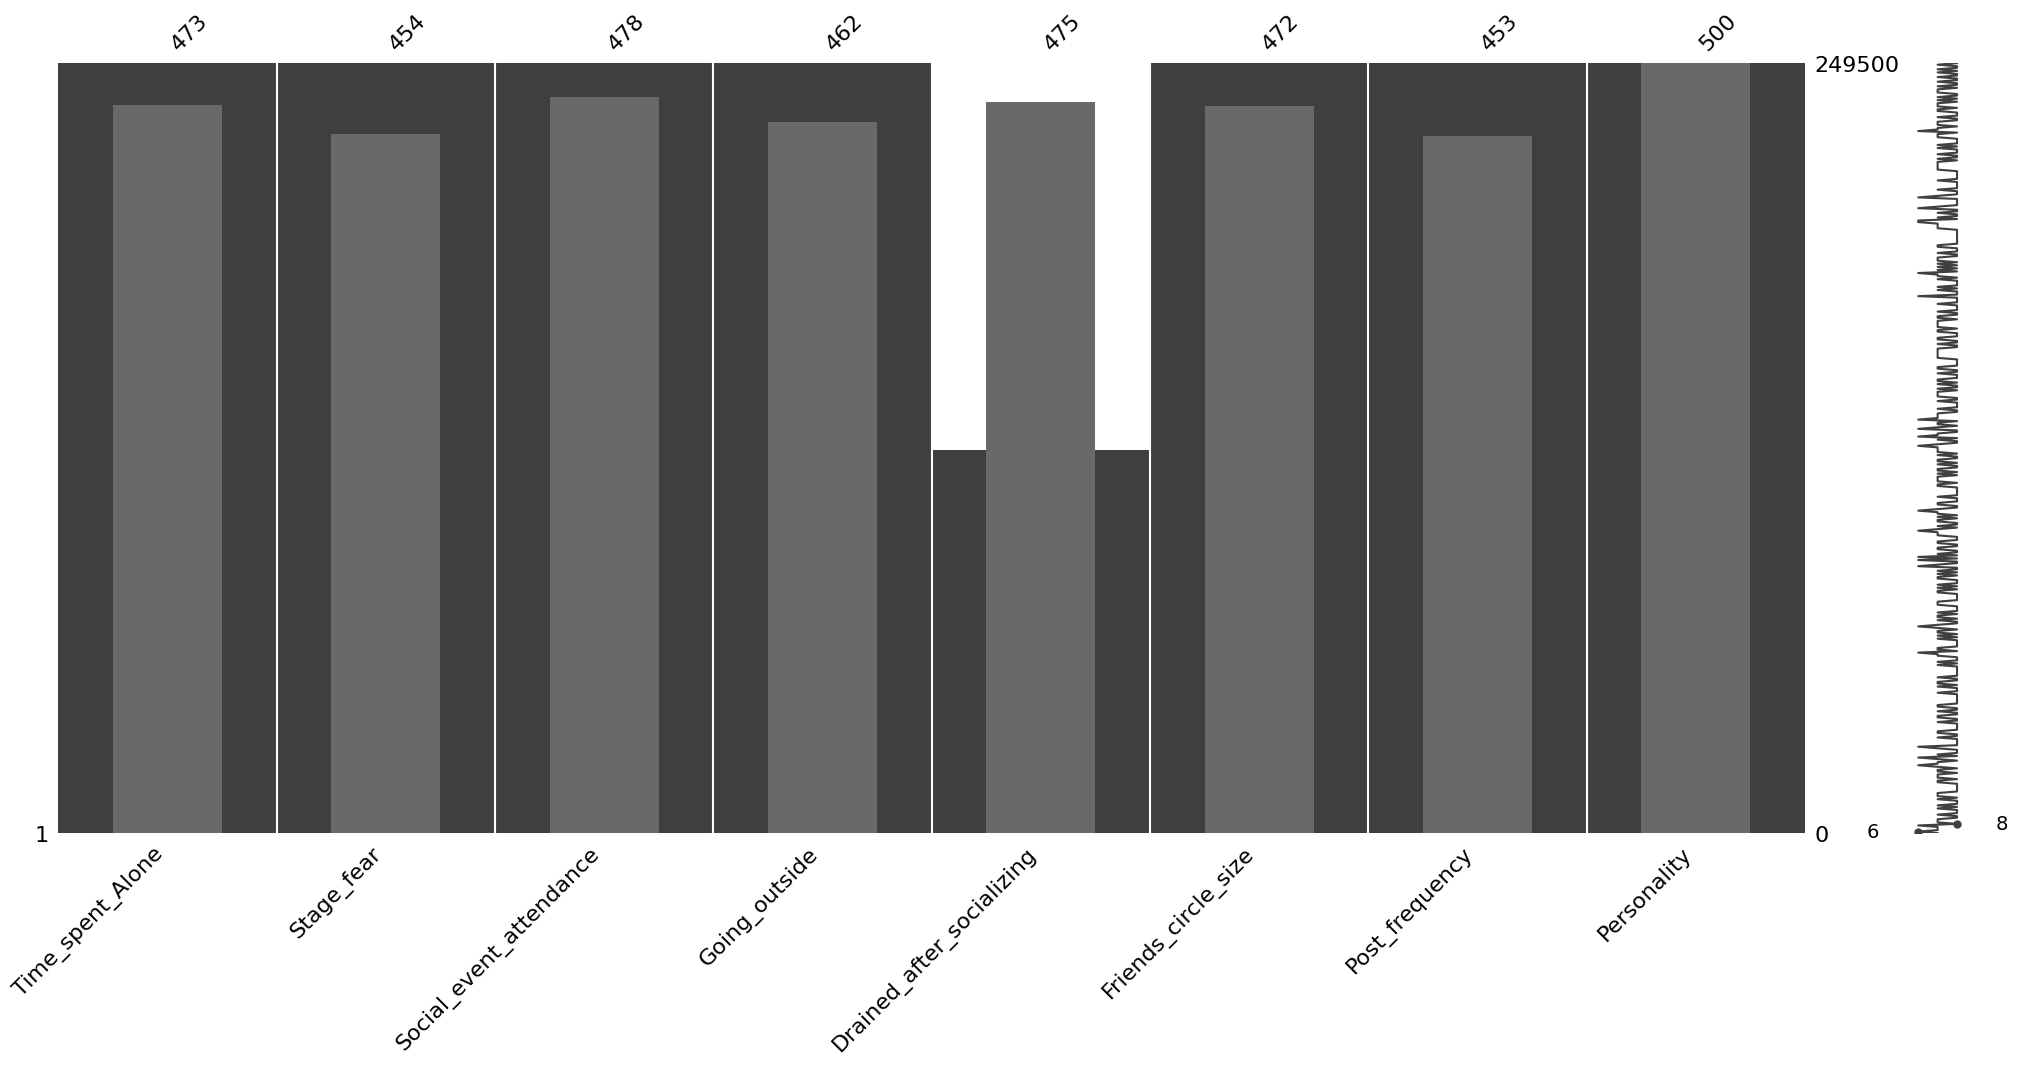

In [12]:
ax = mnso.matrix(train.sample(500))
ax2 = mnso.bar(train.sample(500))

<Axes: >

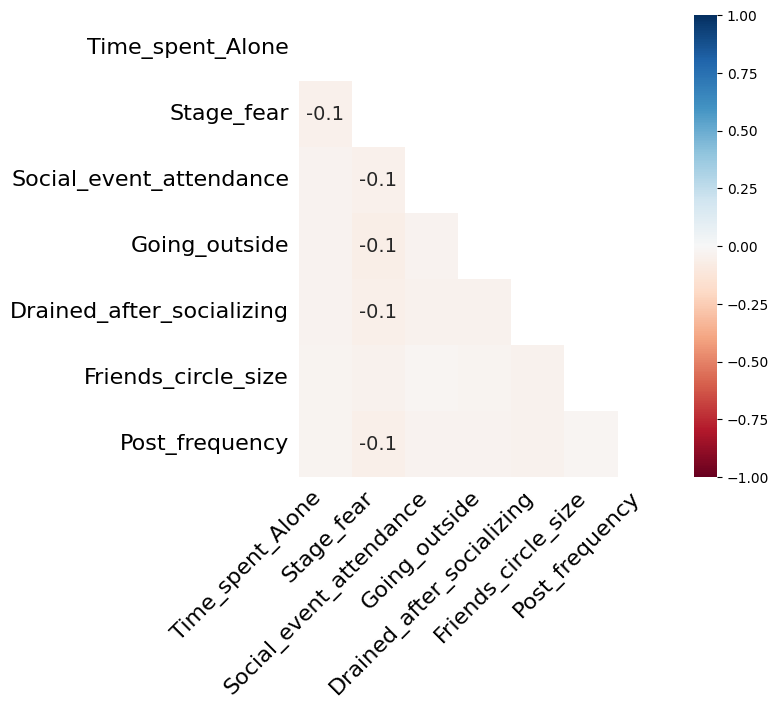

In [13]:
mnso.heatmap(train, figsize=(6,6))

<Axes: >

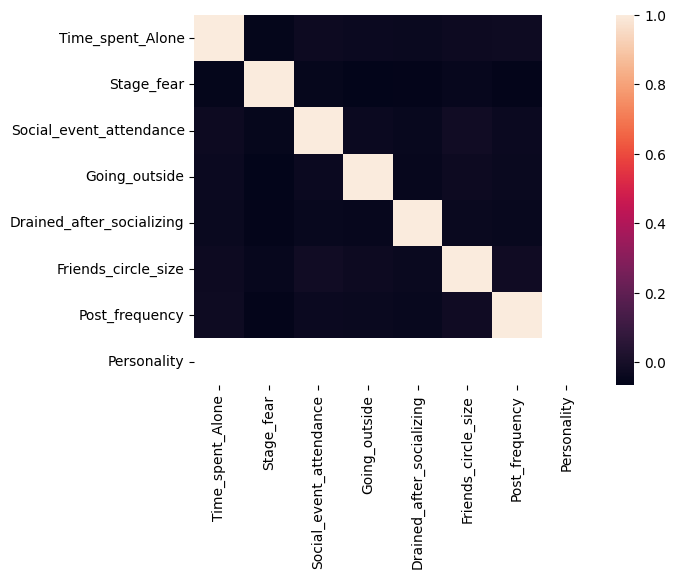

In [14]:
sns.heatmap(train.isnull().corr())

We are going to analyze the distributions of the differents features.

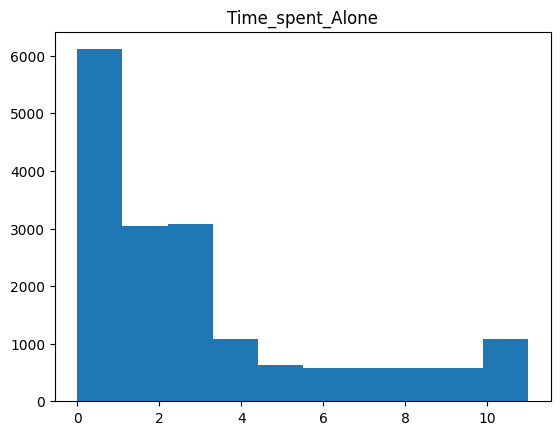

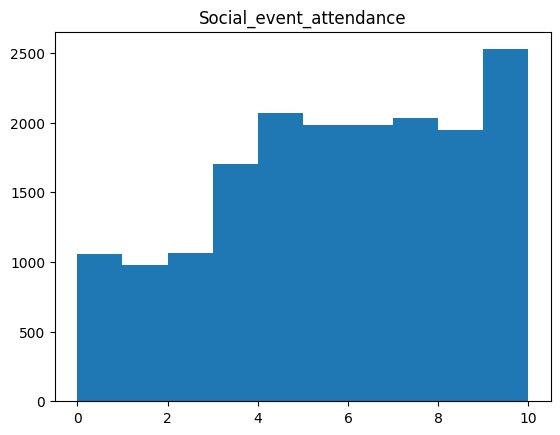

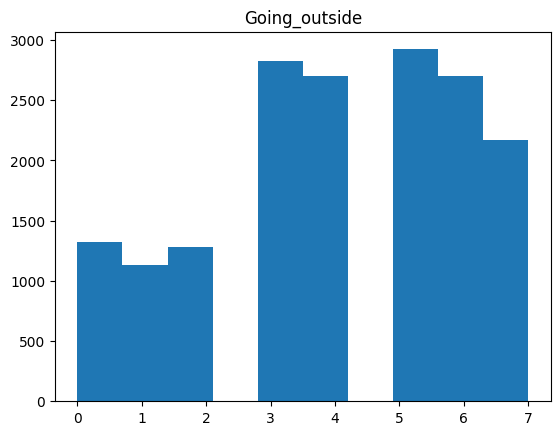

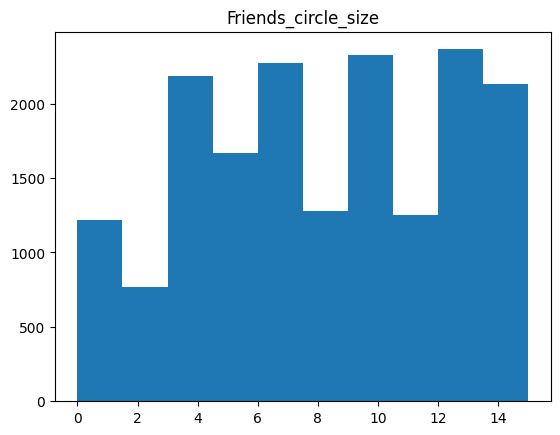

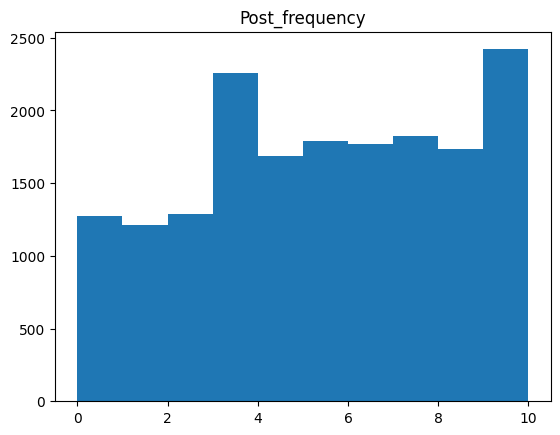

In [15]:
for i in num_f:
    plt.hist(train[i])
    plt.title(i)
    plt.show()

We may need to normalize some variables to have a distribution that looks more like a gaussian distribution.

                         Time_spent_Alone  Social_event_attendance  \
Time_spent_Alone                 1.000000                -0.628806   
Social_event_attendance         -0.628806                 1.000000   
Going_outside                   -0.640884                 0.585224   
Friends_circle_size             -0.598014                 0.566675   
Post_frequency                  -0.611544                 0.566679   

                         Going_outside  Friends_circle_size  Post_frequency  
Time_spent_Alone             -0.640884            -0.598014       -0.611544  
Social_event_attendance       0.585224             0.566675        0.566679  
Going_outside                 1.000000             0.549864        0.579305  
Friends_circle_size           0.549864             1.000000        0.522272  
Post_frequency                0.579305             0.522272        1.000000  


<Axes: >

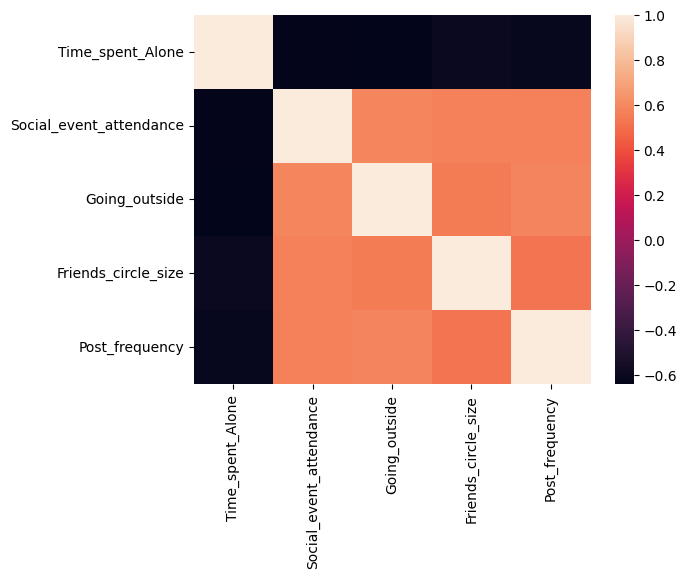

In [16]:
print(train[num_f].corr())
sns.heatmap(train[num_f].corr())

The 'Time_spent_Alone' feature seems to be quite interesting seeing that it seems higly inversed correlated with all the other features.

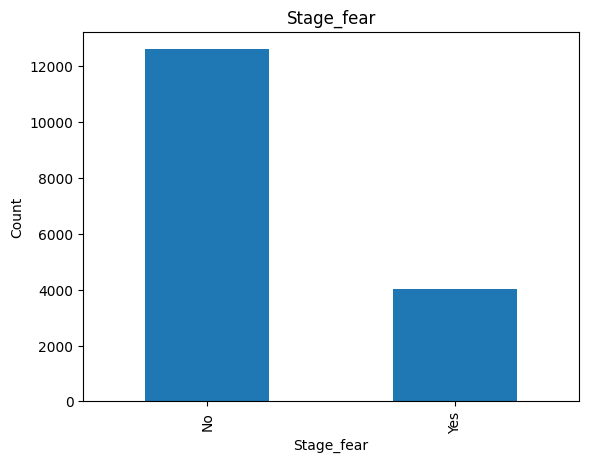

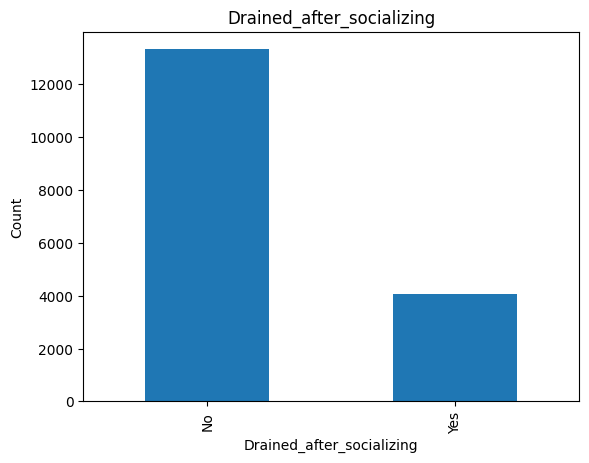

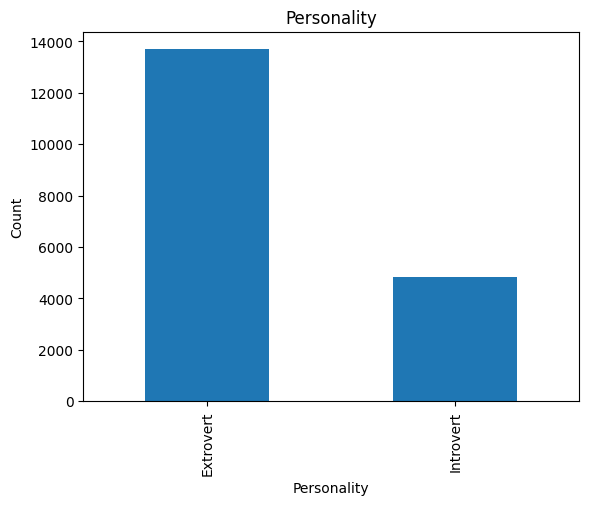

In [17]:
for col in cat_f:
    train[col].value_counts().plot.bar()
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

train['Personality'].value_counts().plot.bar()
plt.title('Personality')
plt.xlabel('Personality')
plt.ylabel("Count")
plt.show()

In [18]:
print(pd.pivot_table(train, index='Time_spent_Alone', columns='Personality', aggfunc='size', fill_value=0))
print(pd.pivot_table(train, index='Stage_fear', columns='Personality', aggfunc='size', fill_value=0))
print(pd.pivot_table(train, index='Drained_after_socializing', columns='Personality', aggfunc='size', fill_value=0))

Personality       Extrovert  Introvert
Time_spent_Alone                      
0.0                    3061         78
1.0                    2903         70
2.0                    2971         68
3.0                    3005         76
4.0                     550        529
5.0                      58        575
6.0                      56        518
7.0                      40        541
8.0                      36        546
9.0                      42        532
10.0                     34        553
11.0                     34        458
Personality  Extrovert  Introvert
Stage_fear                       
No               12314        295
Yes                236       3786
Personality                Extrovert  Introvert
Drained_after_socializing                      
No                             13001        312
Yes                              236       3826


We see an interesting pattern here : the correlation we observed with the matrix seems logical when we observe the datas. 

Social_event_attendance skewness: -0.2292177761491827


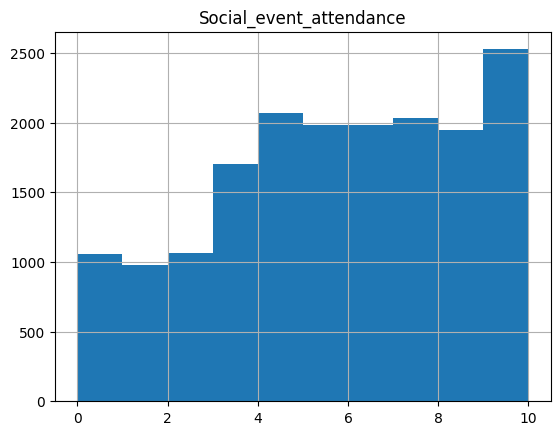

Time_spent_Alone skewness: 1.1336789228142872


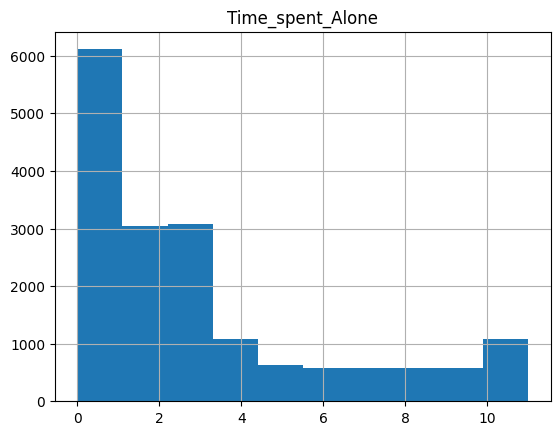

In [19]:
from scipy.stats import skew

for col in ['Social_event_attendance', 'Time_spent_Alone']:
    print(f"{col} skewness: {skew(train[col].dropna())}")
    train[col].dropna().hist(bins=10)
    plt.title(col)
    plt.show()

Avant de passer au feature engineering, nous allons tout d'abord commencer l'imputation. Nous commençons ainsi avec un des premiers choix à discuter : on va imputer avec la médiane chaque feature. On le fait avant le feature engineering car je souhaite réaliser des features issus de la multiplication de 2 autres.

On va inclure notre preprocessing dans la pipeline et dans notre class feature engineering. Je vais dans un premier temps écrire et créer de nouvelles features et faire mon imputation 'à la main' en groupant toutes les données. On a vu que les quatres colonnes intuitives étaient plutôt corrélées entre elles. On va essayer de faire apparaître ça en créeant de nouvelles features en les multipliant entre elles. Cependant on doit d'abbord imputer les colonnes de la valeur qui leur manque.

In [20]:
for feat in num_f:
    X_data[feat] = X_data[feat].fillna(X_data[feat].median())
for feat in cat_f:
    X_data[feat] = X_data[feat].fillna(X_data[feat].mode()[0])

X_data.isna().sum()

Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64

In [21]:
X_data['go*sea'] = (X_data['Going_outside'] + 0.1) * (X_data['Social_event_attendance'] + 0.1)
X_data['go*fcs'] = (X_data['Going_outside'] + 0.1) * (X_data['Friends_circle_size'] + 0.1)
X_data['go*pf']  = (X_data['Going_outside'] + 0.1) * (X_data['Post_frequency'] + 0.1)

X_data['sea*fcs'] = (X_data['Friends_circle_size'] + 0.1) * (X_data['Social_event_attendance'] + 0.1)
X_data['sea*pf']  = (X_data['Post_frequency'] + 0.1) * (X_data['Social_event_attendance'] + 0.1)

X_data['fcs*pf']  = (X_data['Post_frequency'] + 0.1) * (X_data['Friends_circle_size'] + 0.1)

X_data['tsa_norm'] = np.log(X_data['Time_spent_Alone']+1)


Comme la feature 'Time_spent_Alone' est inversement corrélée avec les quatres autres variables, on va créer d'autres features d'intéractions mais en inversant la distribution autour de la valeur centrale de la distribution.

In [22]:
mintsa = X_data['Time_spent_Alone'].min()
maxtsa = X_data['Time_spent_Alone'].max()
#Je vais normaliser ma colonne tsa pour que les outliers prennent moins de place dans les données.

X_data['tsa*sea'] = (1 - (X_data['Time_spent_Alone']-mintsa)/(maxtsa-mintsa) + 0.01) * (X_data['Social_event_attendance'] + 0.1)
X_data['tsa*fcs'] = (1 - (X_data['Time_spent_Alone']-mintsa)/(maxtsa-mintsa) + 0.01) * (X_data['Friends_circle_size'] + 0.1)
X_data['tsa*pf'] = (1 - (X_data['Time_spent_Alone']-mintsa)/(maxtsa-mintsa) + 0.01) * (X_data['Post_frequency'] + 0.1)
X_data['tsa*go'] = (1 - (X_data['Time_spent_Alone']-mintsa)/(maxtsa-mintsa)  + 0.01) * (X_data['Going_outside'] + 0.1)


In [23]:
X_data.columns

Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'go*sea', 'go*fcs', 'go*pf', 'sea*fcs', 'sea*pf',
       'fcs*pf', 'tsa_norm', 'tsa*sea', 'tsa*fcs', 'tsa*pf', 'tsa*go'],
      dtype='object')

We now need to encode and scale our data !

In [24]:
X_data[cat_f] = pd.get_dummies(X_data[cat_f], drop_first=True).astype(int)

In [25]:
scaler = StandardScaler()
scaler.fit(X_data[['Time_spent_Alone', 'Social_event_attendance',
       'Going_outside', 'Friends_circle_size',
       'Post_frequency', 'go*sea', 'go*fcs', 'go*pf', 'sea*fcs', 'sea*pf',
       'fcs*pf', 'tsa*sea', 'tsa*fcs', 'tsa*pf', 'tsa*go', 'tsa_norm']].iloc[:X_train.shape[0]])
X_data[['Time_spent_Alone', 'Social_event_attendance',
       'Going_outside', 'Friends_circle_size',
       'Post_frequency', 'go*sea', 'go*fcs', 'go*pf', 'sea*fcs', 'sea*pf',
       'fcs*pf', 'tsa*sea', 'tsa*fcs', 'tsa*pf', 'tsa*go', 'tsa_norm']] = scaler.transform(X_data[['Time_spent_Alone', 'Social_event_attendance',
       'Going_outside', 'Friends_circle_size',
       'Post_frequency', 'go*sea', 'go*fcs', 'go*pf', 'sea*fcs', 'sea*pf',
       'fcs*pf', 'tsa*sea', 'tsa*fcs', 'tsa*pf', 'tsa*go', 'tsa_norm']])

In [26]:
X_train_scaled = X_data.iloc[:X_train.shape[0]]
X_test_scaled = X_data.iloc[X_train.shape[0]:]

#The datas without the new engineered features
X_train_scaled2 = X_train_scaled[X_train.columns.to_list()]
X_test_scaled2 = X_test_scaled[X_train.columns.to_list()]


In [27]:
le = LabelEncoder()
y_train = 1 - le.fit_transform(y_train)
pd.DataFrame(y_train).value_counts()

0
1    13699
0     4825
Name: count, dtype: int64

<h3>Model Building</h3>
<p>We are firstly going to observe how the different models react, and how they predict without finetuning. I will also see their results on the data without finetuning and the data with.

In [28]:
gnb=GaussianNB()
cv=cross_val_score(gnb, X_train_scaled,y_train,cv=5)
cv2=cross_val_score(gnb, X_train_scaled2, y_train, cv=5)
print(cv,cv2)
print(cv.mean(),cv2.mean())

[0.9659919  0.96815115 0.96275304 0.96437247 0.9724622 ] [0.96815115 0.9705803  0.96302294 0.96653171 0.9724622 ]
0.9667461518058312 0.9681496605777611


In [29]:
lr = LogisticRegression(max_iter=2000)
cv = cross_val_score(lr, X_train_scaled, y_train, cv=5)
cv2 = cross_val_score(lr, X_train_scaled2, y_train, cv=5)
print(cv, cv2)
print(cv.mean(), cv2.mean())

[0.96842105 0.9708502  0.96410256 0.96653171 0.97273218] [0.96815115 0.97031039 0.96437247 0.96707152 0.97408207]
0.9685275428977829 0.9687975212995106


In [57]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_scaled, y_train)

# Récupérer les coefficients
coeffs = lr.coef_[0]

# Associer les features aux coefficients
feature_names = X_train_scaled.columns  # ou list(X_train_scaled.columns)
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coeffs})

# Trier par importance absolue
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Affichage des plus influentes
print(coef_df_sorted[['Feature', 'Coefficient']].head(20))

                      Feature  Coefficient
4   Drained_after_socializing    -1.631161
1                  Stage_fear    -1.518734
6              Post_frequency     1.354820
3               Going_outside     1.259614
5         Friends_circle_size     1.075295
9                       go*pf    -1.045509
14                    tsa*sea     0.968867
7                      go*sea    -0.711891
8                      go*fcs    -0.646854
2     Social_event_attendance     0.635257
10                    sea*fcs    -0.496589
17                     tsa*go     0.331961
13                   tsa_norm     0.290051
0            Time_spent_Alone    -0.279877
11                     sea*pf    -0.274939
12                     fcs*pf    -0.243755
15                    tsa*fcs     0.111626
16                     tsa*pf     0.059578


In [30]:
dt = DecisionTreeClassifier(random_state=1)
cv = cross_val_score(dt, X_train_scaled, y_train, cv=5)
cv2 = cross_val_score(dt, X_train_scaled2, y_train, cv=5)
print(cv, cv2)
print(cv.mean(), cv2.mean())

[0.92955466 0.93144399 0.92415655 0.93036437 0.93547516] [0.92955466 0.92847503 0.92091768 0.93468286 0.93061555]
0.9301989460276376 0.9288491560351286


In [31]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train_scaled, y_train, cv=5)
cv2 = cross_val_score(knn, X_train_scaled2, y_train, cv=5)
print(cv, cv2)
print(cv.mean(), cv2.mean())

[0.96761134 0.97004049 0.96437247 0.9659919  0.97408207] [0.96761134 0.9705803  0.96383266 0.96680162 0.97354212]
0.9684196535532219 0.9684736055123688


In [32]:
rf = RandomForestClassifier(random_state=1)
cv = cross_val_score(rf, X_train_scaled, y_train, cv=5)
cv2 = cross_val_score(rf, X_train_scaled2, y_train, cv=5)
print(cv, cv2)
print(cv.mean(), cv2.mean())

[0.96356275 0.96545209 0.9562753  0.95978408 0.96976242] [0.96275304 0.96734143 0.95735493 0.9611336  0.96949244]
0.9629673286056143 0.9636150873112337


In [41]:
importances = rf.fit(X_train_scaled, y_train).feature_importances_
pd.Series(importances, index=X_train_scaled.columns).sort_values(ascending=False).head(20)

tsa*go                       0.218911
sea*pf                       0.186069
go*sea                       0.129982
tsa*sea                      0.101465
tsa*pf                       0.068294
sea*fcs                      0.053154
go*pf                        0.043484
tsa*fcs                      0.038430
fcs*pf                       0.036703
go*fcs                       0.035853
Drained_after_socializing    0.024149
Stage_fear                   0.022572
Social_event_attendance      0.007940
Going_outside                0.007218
Friends_circle_size          0.006829
Time_spent_Alone             0.006685
Post_frequency               0.006585
tsa_norm                     0.005678
dtype: float64

In [33]:
svc = SVC(probability=True)
cv = cross_val_score(svc, X_train_scaled, y_train, cv=5)
cv2 = cross_val_score(svc, X_train_scaled2, y_train, cv=5)
print(cv, cv2)
print(cv.mean(), cv2.mean())

[0.96842105 0.9708502  0.96410256 0.96707152 0.97408207] [0.96842105 0.97112011 0.96383266 0.96680162 0.97408207]
0.968905483512736 0.9688515024061234


In [34]:
xgb = XGBClassifier(random_state=1)
cv = cross_val_score(xgb, X_train_scaled, y_train, cv=5)
cv2 = cross_val_score(xgb, X_train_scaled2, y_train, cv=5)
print(cv, cv2)
print(cv.mean(), cv2.mean())

[0.965722   0.96977058 0.96140351 0.965722   0.9724622 ] [0.96653171 0.96950067 0.96329285 0.96437247 0.97138229]
0.9670160573388946 0.9670159990439633


In [35]:
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [36]:
cv = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.96815115 0.9708502  0.96410256 0.96707152 0.97462203]
0.9689594937668143


In [37]:
voting_clf.fit(X_train_scaled,y_train)
y_pred = voting_clf.predict(X_test_scaled)
y_pred=pd.DataFrame(y_pred, index=index, columns=["Personality"])
y_pred['Personality'] = y_pred['Personality'].apply(lambda x: 'Extrovert' if int(x) == 1 else 'Introvert')
y_pred.to_csv('pred/basicpres.csv')

In [46]:
X_test_scaled

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,go*sea,go*fcs,go*pf,sea*fcs,sea*pf,fcs*pf,tsa_norm,tsa*sea,tsa*fcs,tsa*pf,tsa*go
id,,,,,,,,,,,,,,,,,,
18524,-0.022156,0,0.657346,-0.020620,0,-0.486882,0.006002,0.239287,-0.477651,-0.174673,-0.163349,0.223206,-0.442790,0.322282,0.344212,-0.495739,-0.139065,-0.158700
18525,-0.364742,1,-1.969365,-2.041578,1,-0.730698,-1.433314,-1.450899,-1.403341,-1.366276,-1.370402,-1.342171,-1.167732,-0.079432,-1.604069,-0.562489,-1.200974,-1.640141
18526,-0.022156,0,-0.093143,0.989859,0,1.707463,1.445319,0.355451,2.057608,1.807512,0.787065,0.665501,2.579226,0.322282,-0.213422,1.122881,0.960116,0.584310
18527,-0.022156,0,-0.468387,-0.020620,0,-0.730698,0.365832,-0.475121,-0.632562,0.060210,-0.795078,-0.262451,-0.442790,0.322282,-0.492239,-0.675586,0.135731,-0.158700
18528,2.033358,1,-1.594120,-1.031099,1,-1.705963,-1.433314,-1.317310,-1.335331,-1.240241,-1.350661,-1.294473,-1.292820,1.601772,-1.555594,-1.541333,-1.461877,-1.478895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24694,-0.022156,0,-0.093143,0.484620,0,0.244566,0.365832,0.059233,0.330912,0.409671,-0.075922,0.002059,0.250881,0.322282,-0.213422,0.043801,0.135731,0.212805
24695,1.690772,1,-1.218876,-1.536339,1,-1.949779,-1.793144,-1.317310,-1.418455,-1.366276,-1.378863,-1.337835,-1.326935,1.454649,-1.410857,-1.585907,-1.529983,-1.525162
24696,-0.364742,0,-0.468387,-0.525859,0,0.244566,0.725661,-0.713258,-0.356744,-0.111656,-0.332562,-0.084666,0.509586,-0.079432,-0.351283,0.245602,0.651099,-0.388200


In [38]:
voting_clf.fit(X_train_scaled2,y_train)
y_pred2 = voting_clf.predict(X_test_scaled2)
y_pred2=pd.DataFrame(y_pred2, index=index, columns=["Personality"])
y_pred2['Personality'] = y_pred2['Personality'].apply(lambda x: 'Extrovert' if x == 1 else 'Introvert')

y_pred2.to_csv('pred/basicpred2.csv')
y_pred2

,Personality
id,
18524,Extrovert
18525,Introvert
18526,Extrovert
18527,Extrovert
18528,Introvert
...,...
24694,Extrovert
24695,Introvert
24696,Extrovert


In [50]:
(y_pred==y_pred2).value_counts()

Personality
True           6173
False             2
Name: count, dtype: int64

In [58]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [60]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train_scaled,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Logistic Regression
Best Score: 0.9686891200889575
Best Parameters: {'C': np.float64(0.03359818286283781), 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [62]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 10, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 10 folds for each of 48 candidates, totalling 480 fits
KNN
Best Score: 0.9688511362695948
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


In [ ]:
svc = SVC()
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = RandomizedSearchCV(estimator=svc,
    param_distributions=param_grid,
    n_iter=30,                  # nombre total de combinaisons testées
    cv=5,                       # validation croisée à 5 plis
    verbose=1,
    n_jobs=-1,                  # utiliser tous les cœurs
    random_state=1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [ ]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [100,500,1000], 
                                  'bootstrap': [True,False],
                                  'max_depth': [3,5,10,20,50,75,100,None],
                                  'max_features': ['auto','sqrt'],
                                  'min_samples_leaf': [1,2,4,10],
                                  'min_samples_split': [2,5,10]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf_rnd = clf_rf_rnd.fit(X_train_scaled,y_train)
clf_performance(best_clf_rf_rnd,'Random Forest')

tsa*go                       0.218911
sea*pf                       0.186069
go*sea                       0.129982
tsa*sea                      0.101465
tsa*pf                       0.068294
sea*fcs                      0.053154
go*pf                        0.043484
tsa*fcs                      0.038430
fcs*pf                       0.036703
go*fcs                       0.035853
Drained_after_socializing    0.024149
Stage_fear                   0.022572
Social_event_attendance      0.007940
Going_outside                0.007218
Friends_circle_size          0.006829
Time_spent_Alone             0.006685
Post_frequency               0.006585
tsa_norm                     0.005678
dtype: float64

In [ ]:
xgb = XGBClassifier()

param_grid = 